In [1]:
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [2]:
import os

cwd = os.getcwd()
cwd
benchmark_result_path = os.path.realpath(
    os.path.join(cwd, "../data/benchmark-results.csv")
)
benchmark_result_path

'/Users/csalih/Developer/bsc-web-benchmark/benchmark/benchmark-analyze/data/benchmark-results.csv'

In [7]:
# Load the dataset
csv_headers = ["framework", "metric", "os", "browser", "value"]
df = pd.read_csv(benchmark_result_path, names=csv_headers)

# Group the data
frameworks = df["framework"].unique()
metrics = df["metric"].unique()
browsers = df["browser"].unique()
operating_systems = df["os"].unique()

df_by_framework = df.groupby('framework')
df_by_metric = df.groupby('metric')

# Display basic info
print(df.head())
print("...")
print(df.tail())

     framework                          metric      os   browser  value
0  app-angular            create_1000_duration  darwin  chromium   56.2
1  app-angular           create_10000_duration  darwin  chromium  558.3
2  app-angular       append_1000_rows_duration  darwin  chromium   60.6
3  app-angular  update_every_10th_row_duration  darwin  chromium    4.6
4  app-angular              swap_rows_duration  darwin  chromium   10.3
...
      framework                          metric     os browser   value
11995   app-vue            create_1000_duration  linux  webkit   243.0
11996   app-vue           create_10000_duration  linux  webkit  2484.0
11997   app-vue       append_1000_rows_duration  linux  webkit   270.0
11998   app-vue  update_every_10th_row_duration  linux  webkit    52.0
11999   app-vue              swap_rows_duration  linux  webkit    76.0


In [8]:
# Validate

# Check if there is sufficient data for ANOVA
if df["framework"].nunique() < 0 or df["browser"].nunique() < 0 or df["os"].nunique() < 0:
    raise Exception(f"Metric {metric} has insufficient data.")


# Group by all factors and count the number of observations
counts = df.groupby(['framework', 'metric', 'browser', 'os']).size().reset_index(name='count')
single_observations = counts[counts['count'] == 1]

if not single_observations.empty:
    print("WARNING: The following groups have only one observation. ANOVA may fail:")
    print(single_observations)
    raise Exception("Consider combining levels or simplifying your model.")

In [9]:
# Initialize a results dictionary
anova_results = {}

for metric, group_df in df_by_metric:    
    # Perform ANOVA for the metric
    model = ols('value ~ C(framework)', data=group_df).fit()
    anova_results[metric] = sm.stats.anova_lm(model, typ=1)

    print("######################################################################")
    print(f"ANOVA Results for Metric: {metric}")
    print("######################################################################")
    print(anova_results[metric])
    print("")

######################################################################
ANOVA Results for Metric: append_1000_rows_duration
######################################################################
                  df        sum_sq        mean_sq          F        PR(>F)
C(framework)     3.0  4.096166e+05  136538.878522  16.840165  7.967048e-11
Residual      2396.0  1.942660e+07    8107.930082        NaN           NaN

######################################################################
ANOVA Results for Metric: create_10000_duration
######################################################################
                  df        sum_sq       mean_sq          F        PR(>F)
C(framework)     3.0  1.023051e+08  3.410169e+07  16.998479  6.341889e-11
Residual      2396.0  4.806763e+09  2.006161e+06        NaN           NaN

######################################################################
ANOVA Results for Metric: create_1000_duration
#################################################

######################################################################
Tukey Results for Metric: append_1000_rows_duration
######################################################################
     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1     group2   meandiff p-adj   lower    upper  reject
--------------------------------------------------------------
app-angular app-leptos   6.4267 0.0262   0.5496 12.3037   True
app-angular  app-react    -4.25 0.2401  -10.127   1.627  False
app-angular    app-vue    -7.55  0.006  -13.427  -1.673   True
 app-leptos  app-react -10.6767    0.0 -16.5537 -4.7996   True
 app-leptos    app-vue -13.9767    0.0 -19.8537 -8.0996   True
  app-react    app-vue     -3.3 0.4627   -9.177   2.577  False
--------------------------------------------------------------
######################################################################
Tukey Results for Metric: create_10000_duration
#########################################################

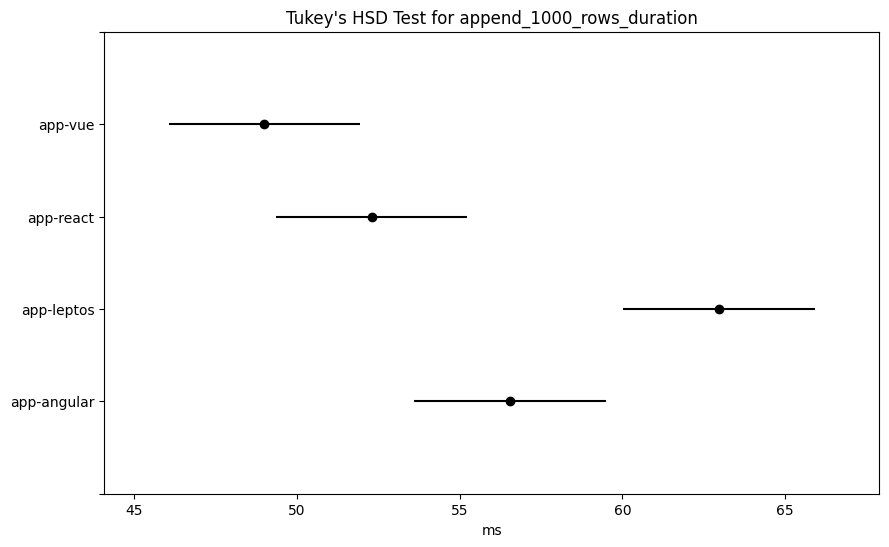

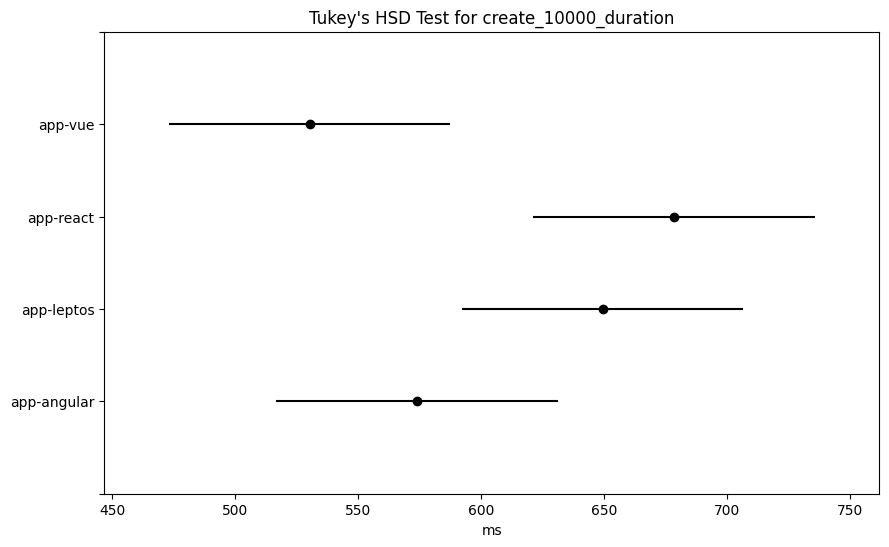

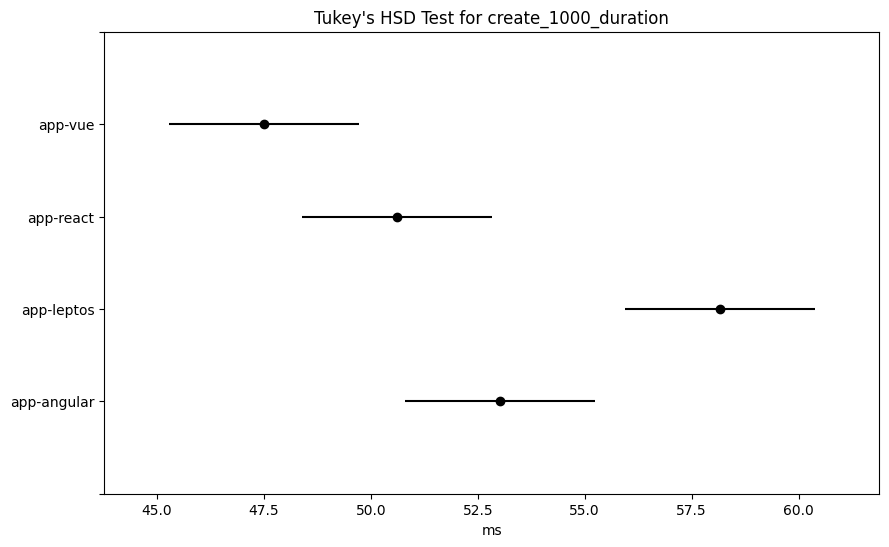

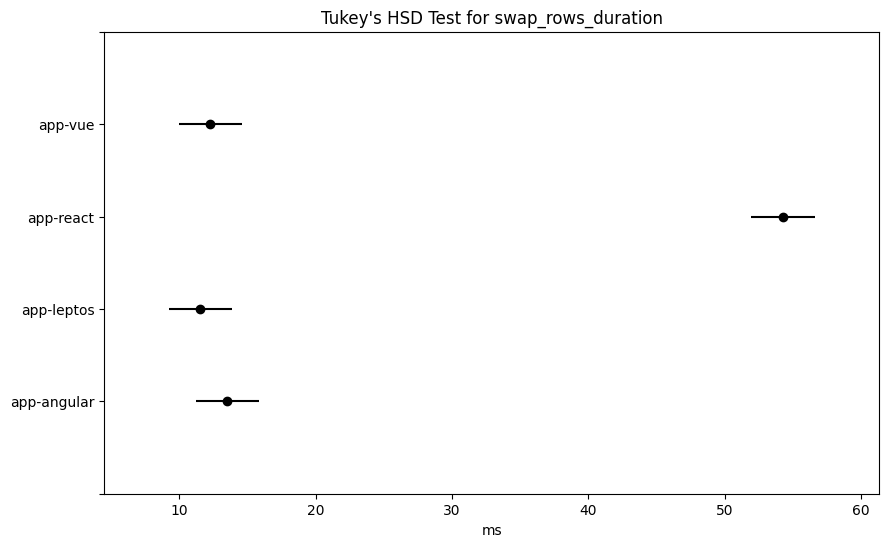

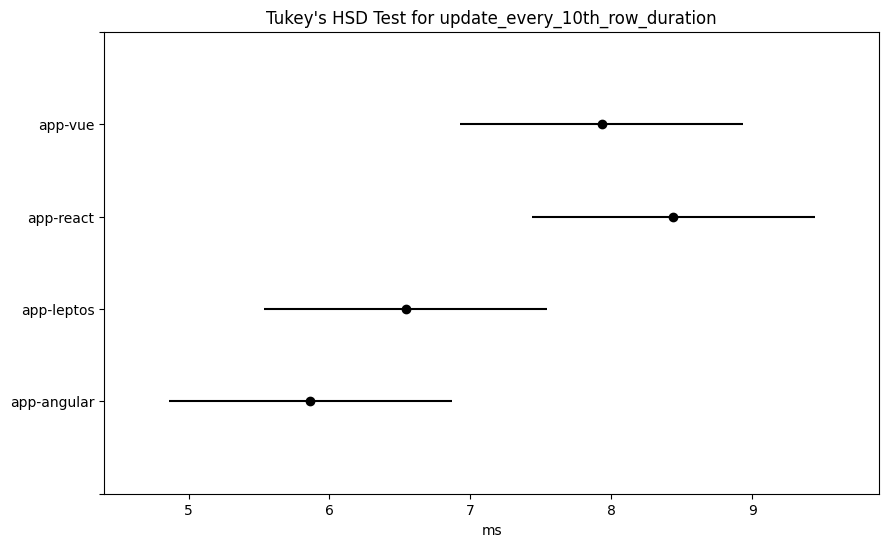

In [75]:
alpha = 0.05
factors = ['framework'] # TODO: add os

# Lets see one metric only
metric = metrics[0]
custom_df = df[df["metric"] == metric]

for metric, group_df in df_by_metric:
    endog=group_df['value']          # Data
    groups=group_df['framework']     # Groups
    
    tukey = pairwise_tukeyhsd(endog, groups, alpha)

    print("######################################################################")
    print(f"Tukey Results for Metric: {metric}")
    print("######################################################################")
    print(tukey.summary())

    # Plot group confidence intervals
    fig, ax = plt.subplots(figsize=(1, 1))
    tukey.plot_simultaneous(ax=ax, xlabel="ms")
    #plt.vlines(x=50, ymin=-0.5, ymax=4.5, color="red")

    ax.set_title(f'Tukey\'s HSD Test for {metric}')